In [66]:
%matplotlib inline

In [67]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels

In [68]:
sys.path.append(os.path.dirname(tr.__file__))

In [69]:
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-ground-truth-segmentation/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline2/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine/checkpoint_49.pt'

In [70]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=False, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=1, CPCCTCNumMatched=16, CPCCTCReductionFactor=4, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, abspos=False, arMode='no_ar', batchSizeGPU=32, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=True, encoder_type='cpc', epsilon=1e-08, file_extension='.flac', gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache=False, learningRate=0.0002, limitNegsInBatch=8

In [71]:
args.pathDB = '/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100'
args.pathTrain = '/pio/gluster/data/ls-train-clean-100/train_split.txt'
args.pathVal = '/pio/gluster/data/ls-train-clean-100/test_split.txt'
args.pathPhone = '/pio/gluster/data/ls-train-clean-100/converted_aligned_phones.txt'
args.size_window = 20480

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))


Loaded from cache /pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt successfully


10it [00:00, 147686.76it/s]

Checking length...
Done, elapsed: 0.006 seconds
Scanned 10 sequences in 0.01 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.151 secs


In [72]:
model.cpu()
if criterion is not None:
    criterion.cpu()
val_loader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
data_iter = iter(val_loader)
batch_data, label = next(data_iter)
c_feature, encoded_data, _ = model(batch_data, None)

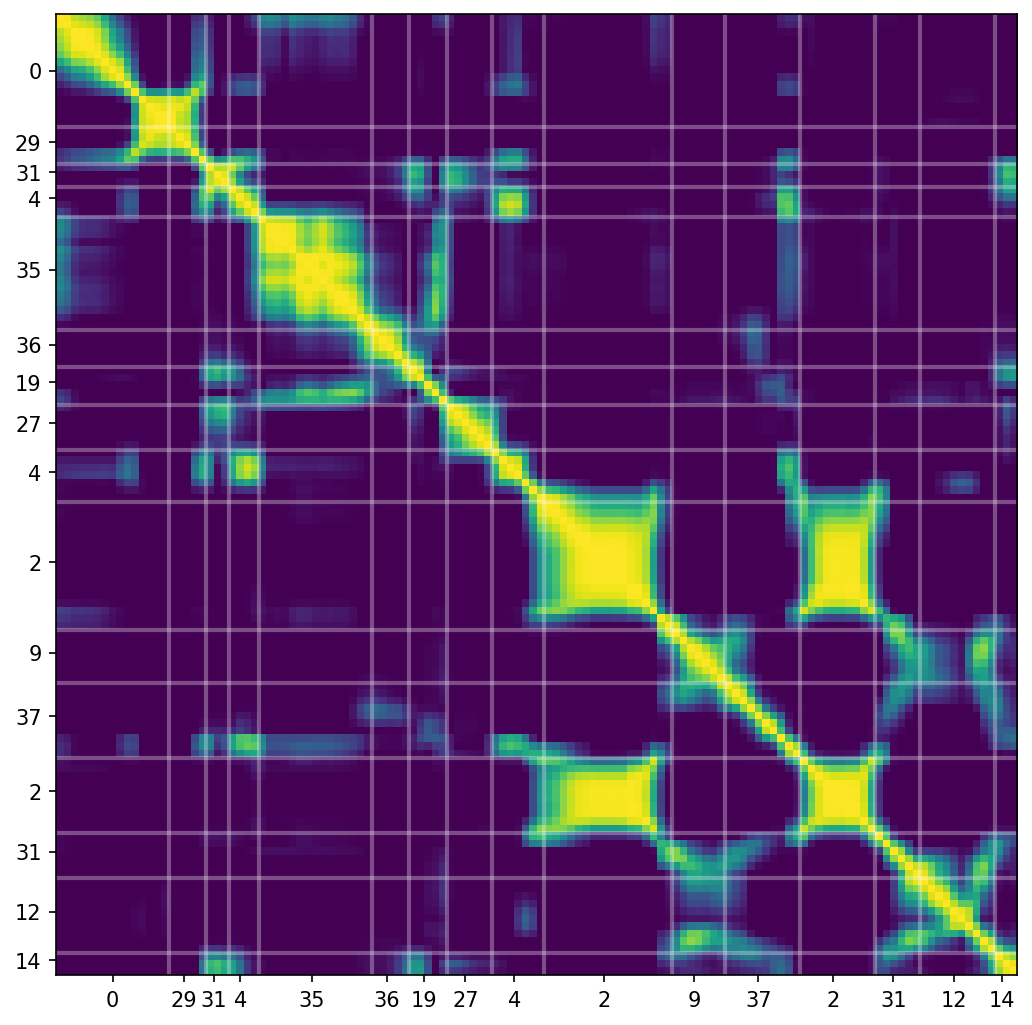

In [73]:
# the paper has these figures
features = encoded_data

trunc = 64  # or None for full plot
trunc = None

plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,:trunc].numpy()

enc = features[0, :trunc, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [str(p) for p in phones[bars[1:]]])
_ = plt.yticks(phone_locs, [str(p) for p in phones[bars[1:]]])
plt.savefig(CP.split('/')[-2])

In [74]:
# waveform = batch_data.cpu().numpy().reshape(-1)
# Z = features.detach().cpu().numpy().reshape(features.shape[1], features.shape[2]).T
# x = np.arange(0, 128)
# y = np.arange(0, 256)
# X, Y = np.meshgrid(x, y)
# # plt.subplot(211)
# # plt.plot(waveform)
# plt.figure(figsize=(7, 7), dpi=150)
# plt.subplot(211)
# plt.specgram(waveform, Fs=16000)
# plt.subplot(212)
# plt.contourf(X, Y, Z, 10)
# plt.tight_layout()
# plt.savefig(CP.split('/')[-2] + '_spectrogram')

In [75]:
phones2codes = {  # phonemes which should be the same for TIMIT
    'a': 0, 'aa': 1, 'aan': 2, 'ae': 3, 'aen': 4, 'ah': 0, 'ahn': 5, 'an': 5, 
    'ao': 6, 'aon': 7, 'aw': 8, 'awn': 9, 'ay': 10, 'ayn': 11, 'b': 12, 'ch': 13, 
    'd': 14, 'dh': 15, 'dx': 16, 'eh': 17, 'ehn': 18, 'el': 19, 'em': 20, 'en': 21, 
    'eng': 22, 'er': 23, 'ern': 24, 'ey': 25, 'eyn': 26, 'f': 27, 'g': 28, 'h': 29, 
    'hh': 29, 'hhn': 30, 'i': 31, 'id': 31, 'ih': 31, 'ihn': 32, 'iy': 33, 'iyih': 32, 
    'iyn': 32, 'jh': 34, 'k': 35, 'l': 36, 'm': 37, 'n': 38, 'ng': 39, 'nx': 40, 
    'ow': 41, 'own': 42, 'oy': 43, 'oyn': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 
    'sh': 49, 't': 50, 'th': 51, 'tq': 46, 'uh': 52, 'uhn': 53, 'uw': 54, 'uwix': 54, 
    'uwn': 55, 'v': 56, 'w': 57, 'y': 58, 'z': 59, 'zh': 60, '-': 61, '###': 62,
    'x': 63, 'no': 64
}

codes2phones = {v: k for k, v in phones2codes.items()}

In [76]:
args.pathDB = '/pio/scratch/1/i325922/data/BUCKEYE/clean/all-clean'
args.pathTrain = '/pio/scratch/1/i325922/data/BUCKEYE/clean/train_split.txt'
args.pathVal = '/pio/scratch/1/i325922/data/BUCKEYE/clean/test_split.txt'
args.pathPhone = '/pio/scratch/1/i325922/data/BUCKEYE/clean/converted_aligned_phones.txt'
args.size_window = 20480

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

Loaded from cache /pio/scratch/1/i325922/data/BUCKEYE/clean/all-clean/_seqs_cache.txt successfully


10it [00:00, 180013.05it/s]

Checking length...
Done, elapsed: 0.003 seconds
Scanned 10 sequences in 0.00 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.446 secs


In [77]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, None)

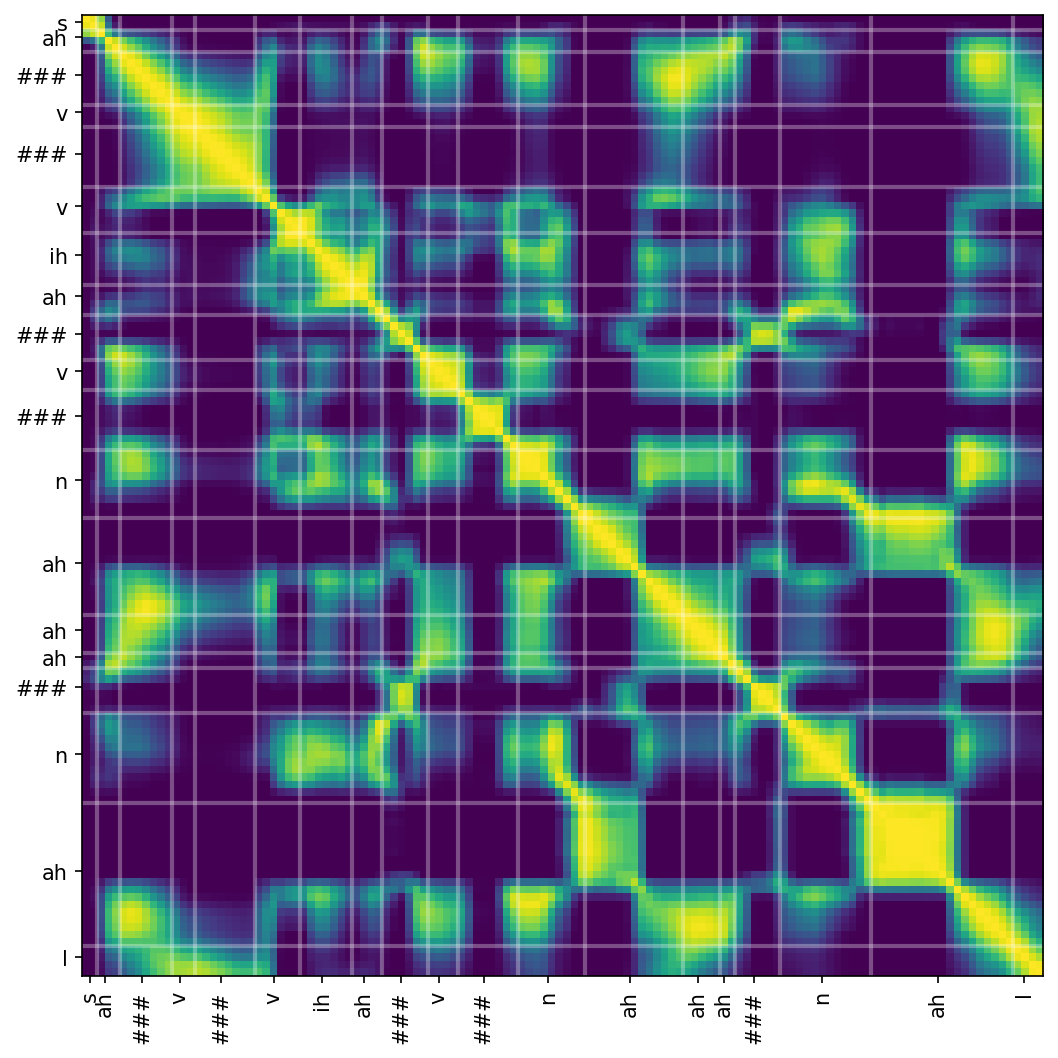

In [78]:
# the paper has these figures
features = encodedData

trunc = 64  # or None for full plot
trunc = None

plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,:trunc].numpy()

enc = features[0, :trunc, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [codes2phones[phones[p]] for p in phones[bars[1:]]], rotation=90)
_ = plt.yticks(phone_locs, [codes2phones[phones[p]] for p in phones[bars[1:]]])
plt.savefig(CP.split('/')[-2] + '_buckeye')